In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import warnings
#import harmonypy as hm
#import scanorama
import scvi
from time import time



warnings.filterwarnings('ignore')

sc.set_figure_params(figsize=(8, 8), dpi=80, dpi_save=600)

/home/ojanen/data/new_conda/envs/heartmap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# List all files in the directory containing the datasets
files = os.listdir('../scCAD/jupyter/qclus/benchmarking/qclus_results/dataset_adatas/selected_samples')

# Initialize an empty list to store the separate sample AnnData objects
separated_samples = []

# Load each dataset and separate it by 'sample_id'
for file in files:
    # Load the dataset
    adata = sc.read_h5ad('../scCAD/jupyter/qclus/benchmarking/qclus_results/dataset_adatas/selected_samples/' + file)
    
    # Get unique sample_ids
    unique_sample_ids = adata.obs['sample_id'].unique()
    
    # Separate the dataset by sample_id and add to the list
    for sample_id in unique_sample_ids:
        # Extract the subset of the data for the current sample_id
        sample_adata = adata[adata.obs['sample_id'] == sample_id].copy()
        
        # Add the separated sample to the list
        separated_samples.append(sample_adata)

# Now separated_samples contains 18 AnnData objects, one for each sample


# all selected samples test

In [3]:
adata = sc.concat(separated_samples, index_unique = '_')

In [4]:
sc.pp.filter_genes(adata, min_cells = 100)

adata.layers['counts'] = adata.X.copy()

scvi.model.SCVI.setup_anndata(adata, layer = "counts",
                             categorical_covariate_keys=["sample_id"],
                             continuous_covariate_keys=['total_counts'])


model = scvi.model.SCVI(adata)

In [ ]:
model.train() 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/100:   4%|█████▎                                                                                                                               | 4/100 [1:07:50<29:20:42, 1100.44s/it, v_num=1, train_loss_step=5.85e+3, train_loss_epoch=5.96e+3]

In [ ]:
adata.obsm['X_scVI'] = model.get_latent_representation()

adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)

sc.pp.neighbors(adata, use_rep = 'X_scVI')

sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['dataset_id', 'sample_id', 'cell_type'], save='_selectedsamples_scVI.png')

In [ ]:
adata.write('data/scvi_adata.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 79673 × 22782
    obs: 'n_counts', 'dataset_id', 'sample_id', 'fraction_unspliced', 'cellranger', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'score_MT', 'total_counts_MT_nucl', 'pct_counts_MT_nucl', 'score_MT_nucl', 'total_counts_CM_cyto', 'pct_counts_CM_cyto', 'score_CM_cyto', 'total_counts_CM_nucl', 'pct_counts_CM_nucl', 'score_CM_nucl', 'total_counts_VEC', 'pct_counts_VEC', 'score_VEC', 'total_counts_PER', 'pct_counts_PER', 'score_PER', 'total_counts_SMC', 'pct_counts_SMC', 'score_SMC', 'total_counts_AD', 'pct_counts_AD', 'score_AD', 'total_counts_SC', 'pct_counts_SC', 'score_SC', 'total_counts_N', 'pct_counts_N', 'score_N', 'total_counts_EEC', 'pct_counts_EEC', 'score_EEC', 'total_counts_FB', 'pct_counts_FB', 'score_FB', 'total_counts_L', 'pct_counts_L', 'score_L', 'total_counts_MESO', 'pct_counts_MESO', 'score_MESO', 'total_counts_MP', 'pct_counts_MP', 'score_MP', 'pct_counts_nonCM', 'score_nonCM', 'total_counts_nu

In [12]:
import scanpy as sc
import scib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the AnnData objects
methods = ['scVI']

adata_objects = {}
adata_objects['scVI'] = adata

# Define the metric calculation functions
def calculate_silhouette(adata, key, embed, metric='euclidean'):
    return scib.metrics.silhouette(adata, key, embed=embed, metric=metric)

# Initialize an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Method', 'Metric', 'Value'])

# Map for embedding
embedding_map = {
    'scVI': 'X_scVI'
}

for method, adata in adata_objects.items():
    print(f"Processing method: {method}")

    embed = embedding_map[method]
    
    # Calculate batch ASW metric
    print(f"Calculating Batch ASW for {method}")
    batch_asw = calculate_silhouette(adata, 'sample_id', embed)
    metrics_df = pd.concat([metrics_df, pd.DataFrame({'Method': [method], 'Metric': ['Batch ASW'], 'Value': [batch_asw]})], ignore_index=True)
    
    # Calculate biological ASW metric
    print(f"Calculating Biological ASW for {method}")
    bio_asw = calculate_silhouette(adata, 'cell_type', embed)
    metrics_df = pd.concat([metrics_df, pd.DataFrame({'Method': [method], 'Metric': ['Biological ASW'], 'Value': [bio_asw]})], ignore_index=True)
    
# Save metrics to CSV
metrics_df.to_csv('scVI_metrics.csv', index=False)


Processing method: scVI
Calculating Batch ASW for scVI


/tmp/ipykernel_100445/403291217.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame({'Method': [method], 'Metric': ['Batch ASW'], 'Value': [batch_asw]})], ignore_index=True)


Calculating Biological ASW for scVI


In [13]:
sc.set_figure_params(dpi_save=600)

/home/ojanen/data/new_conda/envs/heartmap/lib/python3.12/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


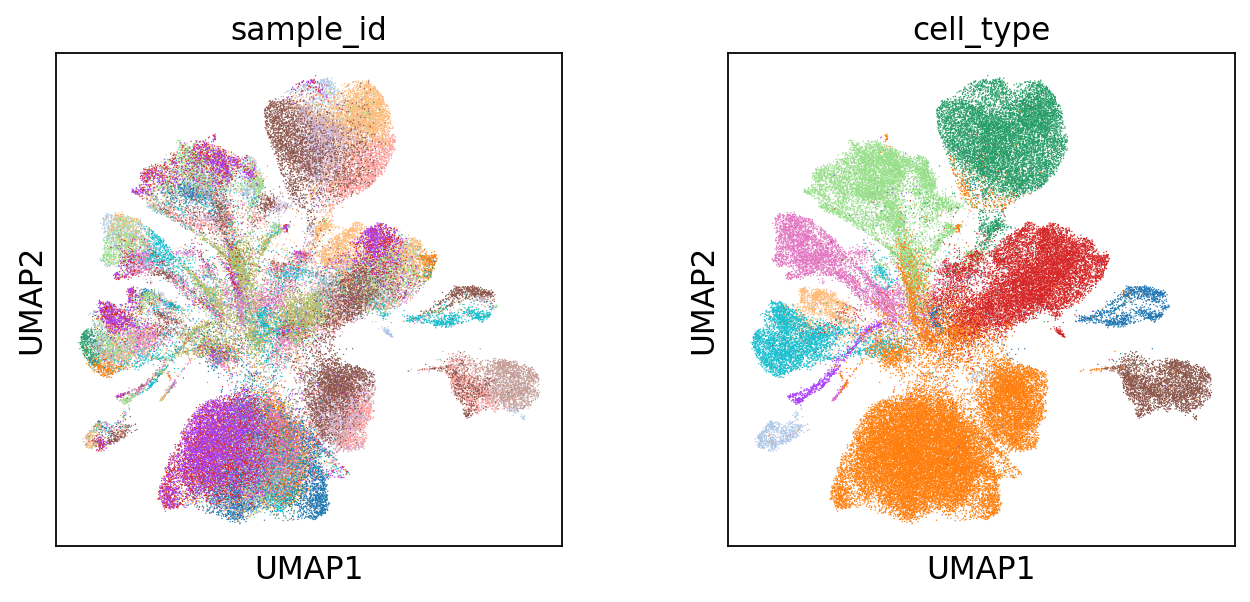

In [17]:
sc.pl.umap(adata, color=['sample_id', 'cell_type'], legend_loc=None, save='_selectedsamples_scVI.png')